In [1]:
import numpy as np
from astropy.io import fits
from matplotlib.pyplot import figure, show, close
from scipy.constants import k, h, c,e
from scipy.optimize import curve_fit

Filename: miles spectra/vega_miles.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   

data shape: (1, 4367)


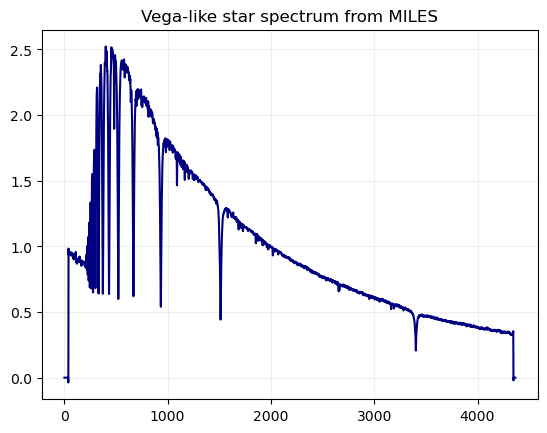

In [2]:
# getting some basic information on the miles spectrum

hdulist = fits.open('miles spectra/vega_miles.fits')
hdulist.info()
print()

hdr = hdulist[0].header
dat = hdulist[0].data
print(f"data shape: {dat.shape}")
vega_miles = dat[0,:]

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(vega_miles,color="navy", label="Vega spectrum")
frame.set_title("Vega-like star spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)


In [3]:
# checking coherence
print(dat.any())
print(dat.all())
print(hdr)

True
False
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 4367 / length of data axis 1                          NAXIS2  =                    1 / length of data axis 2                          COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H COMMENT ----------------------------------------------------------------------  COMMENT ************************** REDUCEME HEADER ***************************  COMMENT ----------------------------------------------------------------------  HISTORY Date: 06/10/**                                                          CRPIX1  =                 1.00                                                  CRVAL1  =            3500.000

In [4]:
hdulist.close()

In [5]:
# defining a gaussian function for fitting the spectra

def f_gaussian(x, amp, mu, sigma, zero):
    """returns the value of a Gaussian function with amplitude amp centered at position mu with width sigma and 
    offset with respect to the x-axis off zero"""
    return amp * np.exp(-(x - mu) * (x - mu) / (2.0 * sigma * sigma)) + zero



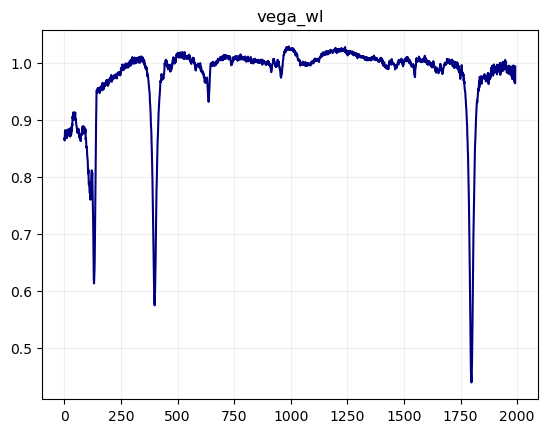

In [6]:
dat_vega_0 = np.loadtxt("flatlined/Flatlined_Vega.txt", comments="#")


fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(dat_vega_0,color="navy", label="Vega spectrum")
frame.set_title("vega_wl")
frame.grid(alpha=0.2)
show()
close(fig)

hdulist.close()



[-5.01377936e-01  1.79909064e+03  9.55606678e+00  9.81707747e-01]


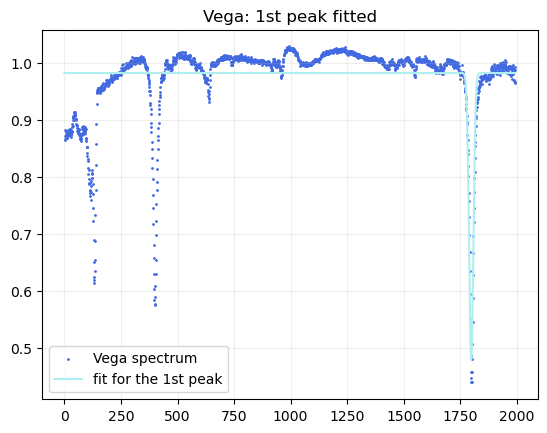

In [7]:
# Making a Gaussian fit for the 1st absorption peak, plotting it

beta, pcov1 = curve_fit(f_gaussian, np.arange(1, dat_vega_0.size+1), dat_vega_0, p0=(-0.6, 1800, 40, 1))
#amp, mu, sigma, zero

print(beta)

a1,m1,s1,z1=beta
x_range = np.arange(1, dat_vega_0.size+1)

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_vega_0,color="royalblue", label="Vega spectrum",s=1)
frame.plot(f_gaussian(x_range,a1,m1,s1,z1),color="paleturquoise", label="fit for the 1st peak")
frame.set_title("Vega: 1st peak fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

In [8]:
# I will take the offset fit for all three peak fits and take the mean, to obtain the average value
# or the weighted average, i'll see which one yields more accurate data

beta, pcov2 = curve_fit(f_gaussian, x_range, dat_vega_0, p0=(-0.2, 400, 20, 1.02))
a2,m2,s2,z2=beta

[0.97981989 0.97981989 0.97981989 ... 0.97981989 0.97981989 0.97981989]


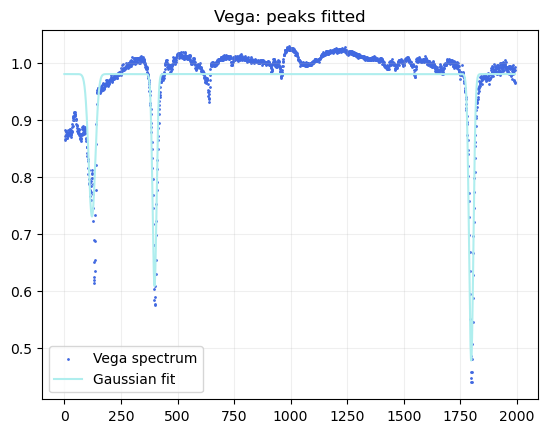

In [9]:
# separate code for the 3rd peak because it's being quirky
# my interpretation: H-alpha (~6600 A), H-beta (~4850 A), O2 band (~6950)

x_range_3rdpeak = np.arange(100,200)

beta, pcov3 = curve_fit(f_gaussian, x_range_3rdpeak, dat_vega_0[100:200], p0=(-0.4, 150, 20, 1.05))

a3,m3,s3,z3=beta

z = np.median([z1,z2,z3])

f_composed = f_gaussian(x_range,a1,m1,s1,z)+f_gaussian(x_range,a2,m2,s2,0)+f_gaussian(x_range,a3,m3,s3,0)
print(f_composed)
fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_vega_0,color="royalblue", label="Vega spectrum",s=1)
frame.plot(f_composed,color="paleturquoise", label="Gaussian fit")
frame.set_title("Vega: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

In [10]:
def fwhm_calculator(sigma,pcov):
    """Calculates the equivalent width from a given sigma value and its error using the pcov matrix"""
    fwhm=2*sigma*np.sqrt(2*np.log(2))
    err=np.sqrt(np.diag(pcov))
    fwhm_err=2*err[2]*np.sqrt(2*np.log(2))
    return fwhm,fwhm_err

fwhm1,fwhm1_err=fwhm_calculator(s1,pcov1)
fwhm2,fwhm2_err=fwhm_calculator(s2,pcov2)
fwhm3,fwhm3_err=fwhm_calculator(s3,pcov3)

print(f"H-beta peak width: {fwhm1}, error: {fwhm1_err}")
print(f"H-alpha peak width: {fwhm2}, error: {fwhm2_err}")
print(f"O2 band width: {fwhm3}, error: {fwhm3_err}")

H-beta peak width: 22.502817612489604, error: 0.8682480735126517
H-alpha peak width: 20.850817354068557, error: 1.2992815838759997
O2 band width: 35.035210222397396, error: 2.533911513967096


In [11]:
# defining points for plotting the FWHMs

fwhm1_x=np.array((m1-fwhm1/2,m1+fwhm1/2))
fwhm1_y=np.array((a1/2+z,a1/2+z))

fwhm2_x=np.array((m2-fwhm2/2,m2+fwhm2/2))
fwhm2_y=np.array((a2/2+z,a2/2+z))

fwhm3_x=np.array((m3-fwhm3/2,m3+fwhm3/2))
fwhm3_y=np.array((a3/2+z,a3/2+z))

-1.217 7060
H-alpha peak width: -27.38592903439985 Angstroms, error: -1.0566579054648972
H-beta peak width: -25.375444719901434 Angstroms, error: -1.5812256875770918
O2 band width: -42.637850840657634 Angstroms, error: -3.083770312497956
H-beta peak position: 4870.506694495747 Angstroms
H-alpha peak position: 6573.85473810513 Angstroms
O2 band peak position: 6910.43 Angstroms


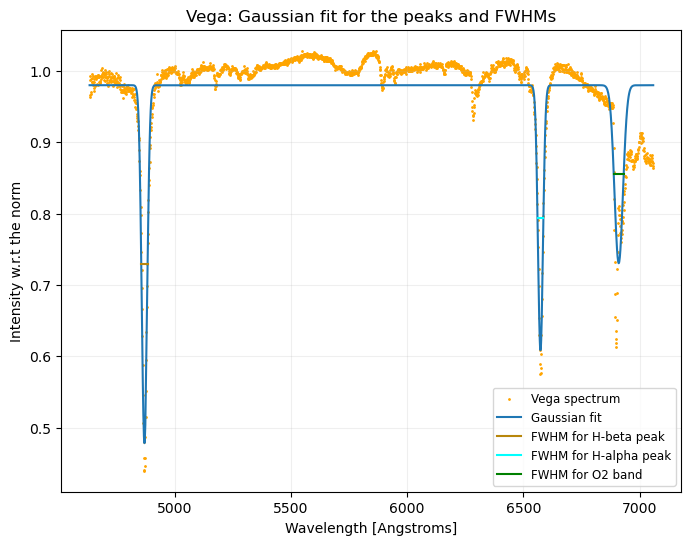

In [12]:
# Converting the values from pixels to Angstroms using values from wavelength calibration

a_in_pix=-1.217
a_off = 7060

def pix_to_A (a):
    """Function to simplify the conversion of values/numpy array from values in pixels to Angstroms"""
    return a*a_in_pix+a_off

x_range_a = pix_to_A(x_range)
x_range_a = a_in_pix*x_range + a_off
print(a_in_pix,a_off)

print(f"H-alpha peak width: {a_in_pix*fwhm1} Angstroms, error: {a_in_pix*fwhm1_err}")
print(f"H-beta peak width: {a_in_pix*fwhm2} Angstroms, error: {a_in_pix*fwhm2_err}")
print(f"O2 band width: {a_in_pix*fwhm3} Angstroms, error: {a_in_pix*fwhm3_err}")

m1_a = pix_to_A(m1)
m2_a = pix_to_A(m2)
m3_a = pix_to_A(m3)

print(f"H-beta peak position: {m1_a} Angstroms")
print(f"H-alpha peak position: {m2_a} Angstroms")
print(f"O2 band peak position: {m3_a:.2f} Angstroms")



fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_a,dat_vega_0,color="orange", label="Vega spectrum",s=1)
frame.plot(x_range_a,f_composed, label="Gaussian fit")
frame.plot(fwhm1_x*a_in_pix+a_off,fwhm1_y,color="darkgoldenrod", label="FWHM for H-beta peak")
frame.plot(fwhm2_x*a_in_pix+a_off,fwhm2_y,color="cyan", label="FWHM for H-alpha peak")
frame.plot(fwhm3_x*a_in_pix+a_off,fwhm3_y,color="green", label="FWHM for O2 band")
frame.set_title("Vega: Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=8.5)
show()
close(fig)

# C R I S P

#wavelength calibration from Stefan: -1.217x + 7060
        

[1.7904861  1.8005823  1.80714    ... 0.38567284 0.3792054  0.37885448]


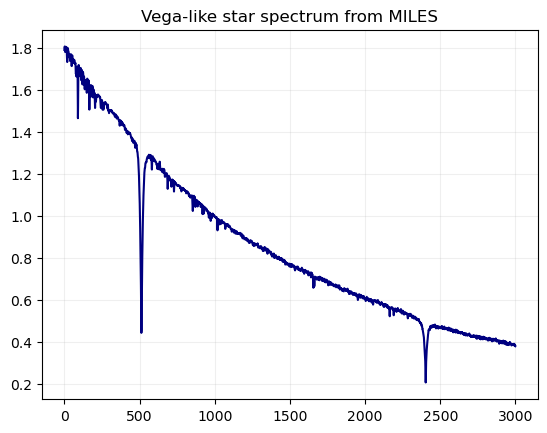

[1.7904861  1.8005823  1.80714    ... 0.38567284 0.3792054  0.37885448]


In [13]:
# the fight with MILES continues

print(vega_miles[1000:4000])

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(vega_miles[1000:4000],color="navy", label="Vega spectrum") # the section of the data that seems relevant
frame.set_title("Vega-like star spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

print(vega_miles[1000:4000])

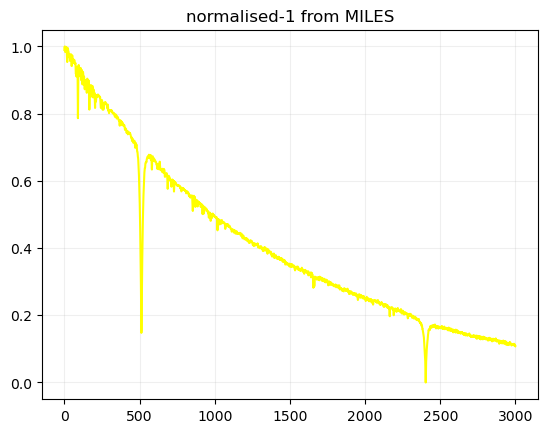

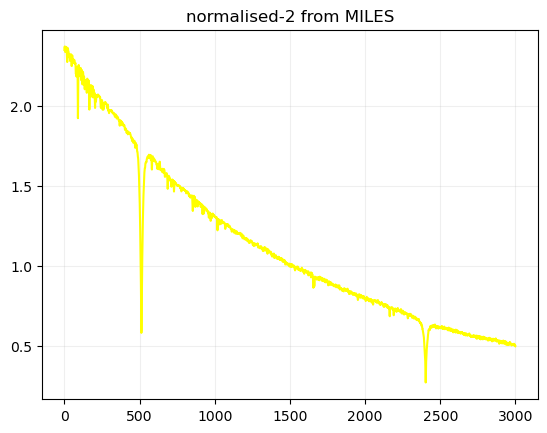

In [14]:
# defining the normalization function using the normal statistics formula
def normalize_spectrum(wavelengths, intensities):
    min_intensity = np.min(intensities)
    max_intensity = np.max(intensities)
    normalized_intensities = (intensities - min_intensity) / (max_intensity - min_intensity)
    return normalized_intensities

#defining the normalization function using some quirky thing from PROGNUM material
def normalize_quirky(wavelengths, intensities):
    normalised_spectrum = intensities/np.median(intensities)
    return normalised_spectrum
    

x_range_miles=np.arange(1000, 4000)

normalized_vega_miles = normalize_spectrum(x_range_miles, vega_miles[1000:4000])

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(normalized_vega_miles,color="yellow", label="Vega spectrum") 
frame.set_title("normalised-1 from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

normalized_vega_miles2 = normalize_quirky(x_range_miles, vega_miles[1000:4000])

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(normalized_vega_miles2,color="yellow", label="Vega spectrum")
frame.set_title("normalised-2 from MILES")
frame.grid(alpha=0.2)
show()
close(fig)


In [15]:
def f_exp(x, a,b,z):
    """returns an exponential function of the form a*exp(b*x)"""
    return a*np.exp(b*x)+z

[ 3.10703171e+00 -6.63677636e-04  1.69436070e-01]


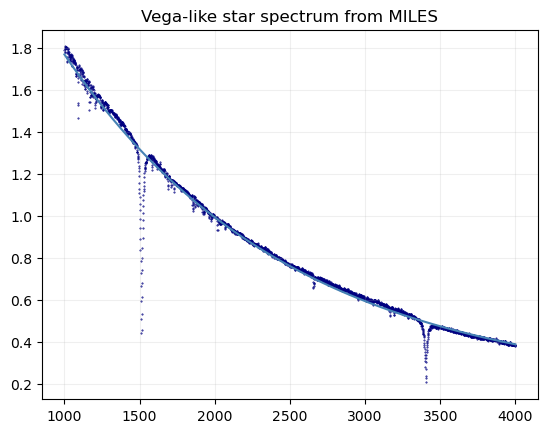

In [16]:
# fitting exponential curve to the miles Vega

beta, pcov = curve_fit(f_exp, x_range_miles, vega_miles[1000:4000], p0=[2,-0.001,0.4])

print(beta)
exp_a,exp_b,exp_z = beta

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_miles,vega_miles[1000:4000],color="navy", label="Vega spectrum", s=0.2) # the section of the data that seems relevant
frame.plot(x_range_miles, f_exp(x_range_miles,exp_a,exp_b,exp_z), color="steelblue", label='Fitted Exponential Curve')
frame.set_title("Vega-like star spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

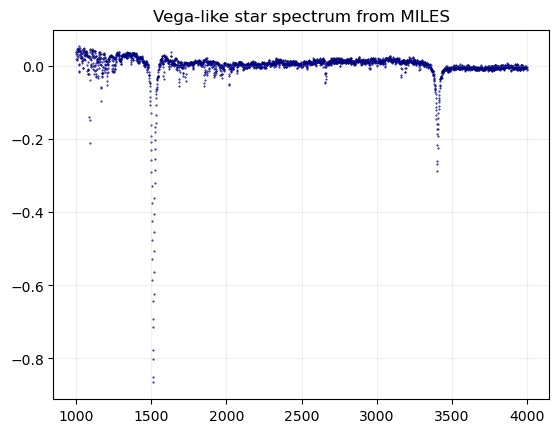

In [17]:
# subtracting the exponential fit from the MILES data to obtain a straight line
vega_miles_line=vega_miles[1000:4000]-f_exp(x_range_miles,exp_a,exp_b,exp_z)

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_miles,vega_miles_line,color="navy", label="Vega spectrum", s=0.2) # the section of the data that seems relevant
frame.set_title("Vega-like star spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

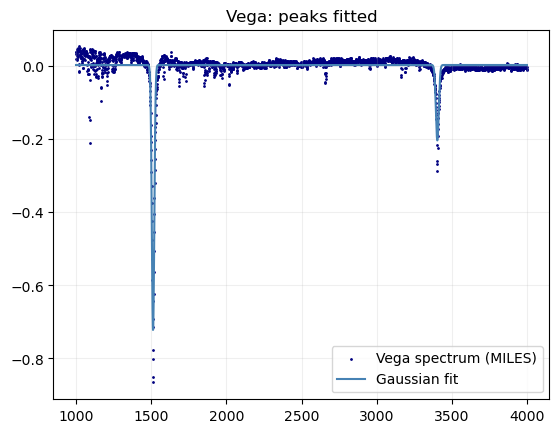

In [18]:
beta, pcov1 = curve_fit(f_gaussian, x_range_miles, vega_miles_line, p0=(-0.85,1500,100,0))
a1,m1,s1,z1=beta
beta, pcov2 = curve_fit(f_gaussian, x_range_miles, vega_miles_line, p0=(-0.3,3400,100,0))
a2,m2,s2,z2=beta

z=np.mean([z1,z2])

f_composed = f_gaussian(x_range_miles,a1,m1,s1,z)+f_gaussian(x_range_miles,a2,m2,s2,0)

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_miles,vega_miles_line,color="navy", label="Vega spectrum (MILES)",s=1)
frame.plot(x_range_miles,f_composed,color="steelblue", label="Gaussian fit")
frame.set_title("Vega: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

H-beta peak width: -19.48093458624747, error: 0.22596831013157642
H-alpha peak width: 22.61629757885381, error: 2.00415581185561
H-beta peak position: 4861.153229175802 Angstroms
H-alpha peak position: 6562.70181940233 Angstroms
H-beta peak width: -17.532841127622724 Angstroms, error: 0.2033714791184188
H-alpha peak width: 20.35466782096843 Angstroms, error: 1.8037402306700492


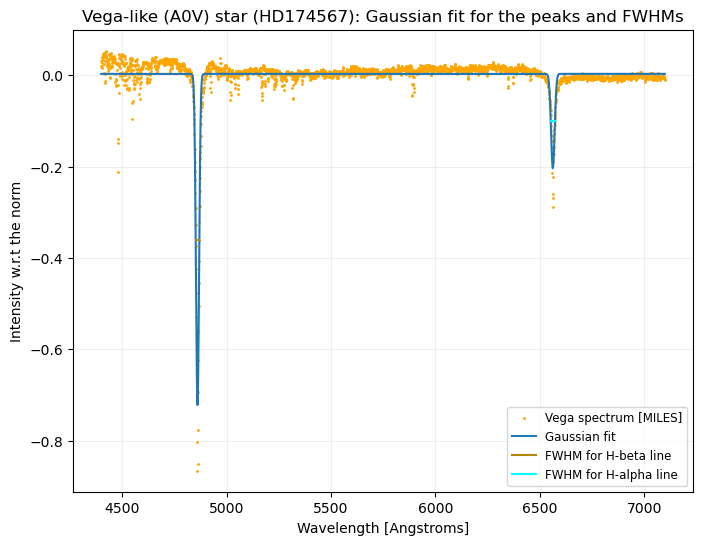

In [19]:
a_in_pix,a_off = 0.9, 3500 # information from the MILES data header file


fwhm1,fwhm1_err=fwhm_calculator(s1,pcov1)
fwhm2,fwhm2_err=fwhm_calculator(s2,pcov2)

fwhm1_x=np.array((m1-fwhm1/2,m1+fwhm1/2))
fwhm1_y=np.array((a1/2+z,a1/2+z))

fwhm2_x=np.array((m2-fwhm2/2,m2+fwhm2/2))
fwhm2_y=np.array((a2/2+z,a2/2+z))

m1_a = a_in_pix*m1+a_off
m2_a = a_in_pix*m2+a_off

print(f"H-beta peak width: {fwhm1}, error: {fwhm1_err}")
print(f"H-alpha peak width: {fwhm2}, error: {fwhm2_err}")
print(f"H-beta peak position: {m1_a} Angstroms")
print(f"H-alpha peak position: {m2_a} Angstroms")

x_range_miles_a = x_range_miles*a_in_pix+a_off

print(f"H-beta peak width: {a_in_pix*fwhm1} Angstroms, error: {a_in_pix*fwhm1_err}")
print(f"H-alpha peak width: {a_in_pix*fwhm2} Angstroms, error: {a_in_pix*fwhm2_err}")

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_miles_a,vega_miles_line,color="orange", label="Vega spectrum [MILES]",s=1)
frame.plot(x_range_miles_a,f_composed, label="Gaussian fit")
frame.plot(fwhm1_x*a_in_pix+a_off,fwhm1_y,color="darkgoldenrod", label="FWHM for H-beta line")
frame.plot(fwhm2_x*a_in_pix+a_off,fwhm2_y,color="cyan", label="FWHM for H-alpha line")
frame.set_title("Vega-like (A0V) star (HD174567): Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=8.5)
show()
close(fig)

here's the GitHub commit message prefixes:
-feat (add feature)
-fix (repaired bug/broken code)
-refactor (changed code structure but didnt add new features)
-style (if you just changed some minor thing, spelling, variable names, ect.)